### pCrunch Update

Jake Nunemaker

Last Updated: 02/08/2021

In [30]:
import os
from fnmatch import fnmatch

import numpy as np
import pandas as pd
import ruamel_yaml as ry

import matplotlib.pyplot as plt

from weis.aeroelasticse import FileTools

rpm2RadSec = 2.0*(np.pi)/60.0


from pCrunch import LoadsAnalysis, PowerProduction, FatigueParams
from pCrunch.io import load_FAST_out
from pCrunch.utility import save_yaml, get_windspeeds, convert_summary_stats

def valid_extension(fp):
    return any([fnmatch(fp, ext) for ext in ["*.outb", "*.out"]])

In [3]:

fname_case_matrix = '/Users/dzalkind/Tools/ROSCO/outputs/PRC_2/IEA15MW_PRC/power_curve/base/case_matrix.yaml'
cm_dict = FileTools.load_yaml(fname_case_matrix, package=1)
cnames = []
for c in list(cm_dict.keys()):
    if isinstance(c,ry.comments.CommentedKeySeq):
        cnames.append(tuple(c))
    else:
        cnames.append(c)
        
cm = pd.DataFrame(cm_dict, columns=cnames)

if ('DLC','Label') in cm:
    cm[('DLC','Label')].unique()

    dlc_inds = {}

    for dlc in cm[('DLC','Label')].unique():
        dlc_inds[dlc] = cm[('DLC','Label')] == dlc
    
cm

,"(AeroDyn15, AFAeroMod)","(AeroDyn15, AIDrag)","(AeroDyn15, HubLoss)","(AeroDyn15, IndToler)","(AeroDyn15, MaxIter)","(AeroDyn15, SkewMod)","(AeroDyn15, TIDrag)","(AeroDyn15, TanInd)","(AeroDyn15, TipLoss)","(AeroDyn15, TwrAero)",...,"(ServoDyn, GenTiStp)","(ServoDyn, GenTiStr)","(ServoDyn, HSSBrMode)","(ServoDyn, PCMode)","(ServoDyn, SpdGenOn)","(ServoDyn, TimGenOn)","(ServoDyn, VSContrl)","(ServoDyn, YCMode)",Case_ID,Case_Name
0,2,True,True,0.00001,5000,1,True,True,True,False,...,True,True,5,5,0.0,0.0,5,5,0,IEA15MW_PRC_00
1,2,True,True,0.00001,5000,1,True,True,True,False,...,True,True,5,5,0.0,0.0,5,5,1,IEA15MW_PRC_01
2,2,True,True,0.00001,5000,1,True,True,True,False,...,True,True,5,5,0.0,0.0,5,5,2,IEA15MW_PRC_02
3,2,True,True,0.00001,5000,1,True,True,True,False,...,True,True,5,5,0.0,0.0,5,5,3,IEA15MW_PRC_03
4,2,True,True,0.00001,5000,1,True,True,True,False,...,True,True,5,5,0.0,0.0,5,5,4,IEA15MW_PRC_04
5,2,True,True,0.00001,5000,1,True,True,True,False,...,True,True,5,5,0.0,0.0,5,5,5,IEA15MW_PRC_05
6,2,True,True,0.00001,5000,1,True,True,True,False,...,True,True,5,5,0.0,0.0,5,5,6,IEA15MW_PRC_06
7,2,True,True,0.00001,5000,1,True,True,True,False,...,True,True,5,5,0.0,0.0,5,5,7,IEA15MW_PRC_07
8,2,True,True,0.00001,5000,1,True,True,True,False,...,True,True,5,5,0.0,0.0,5,5,8,IEA15MW_PRC_08
9,2,True,True,0.00001,5000,1,True,True,True,False,...,True,True,5,5,0.0,0.0,5,5,9,IEA15MW_PRC_09


#### Project Directory

In [5]:
output_dir = "/Users/dzalkind/Tools/ROSCO/outputs/PRC_2/IEA15MW_PRC/power_curve/base"
# results_dir = os.path.join(output_dir, "results")
# save_results = True

# outfiles = [
#     os.path.join(output_dir, f) for f in os.listdir(output_dir)
#     if valid_extension(f)
# ]

outfiles = [os.path.join(output_dir,f'IEA15MW_PRC_{i:02d}.out') for i  in range(len(cm))]

# iea15mw_04.HD

# /projects/esteyco/dzalkind/02_DLC_02_1661_Wide/rank_0/IEA15_00.out

print(f"Found {len(outfiles)} files.")

Found 16 files.


#### Interacting with output files

In [37]:
# The new framework provides an object oriented framework to interact with
# output files. The easiest way to use this is to use the 'load_FAST_out' function.

# load_FAST_out(filenames, tmin=0, tmax=np.inf, cores=1, **kwargs)
# outputs = load_FAST_out(outfiles,tmin=120,cores=12)
# outputs

In [20]:
# An instance of 'OpenFASTBinary' (or 'OpenFASTAscii' if applicable) is created.
# The instance stores the raw data but also provides many useful methods for
# interacting with the data:

# print(outputs[0].data)
# print(outputs[0].time)
# print(outputs[0].channels)
# print(outputs[0].maxima)
# print(outputs[0].stddevs)

# Individual channel time series can also be accessed with dict style indexing:
outputs[0]["Wind1VelX"]

array([10.85912037, 10.77266312, 10.68620682, ..., 13.05524254,
       13.10151958, 13.14779663])

#### pCrunch Configuration

In [6]:
# Channel magnitudes are defined in a dict:
magnitude_channels = {
    "RootMc1": ["RootMxc1", "RootMyc1", "RootMzc1"],
    "RootMc2": ["RootMxc2", "RootMyc2", "RootMzc2"],
    "RootMc3": ["RootMxc3", "RootMyc3", "RootMzc3"],
}

# Define channels (and their fatigue slopes) in a dict:
fatigue_channels = {
    "RootMc1": FatigueParams(lifetime=25.0, slope=10.0, ult_stress=6e8),
    "RootMc2": FatigueParams(lifetime=25.0, slope=10.0, ult_stress=6e8),
    "RootMc3": FatigueParams(lifetime=25.0, slope=10.0, ult_stress=6e8),
}

# Define channels to save extreme data in a list:
channel_extremes = [
    "RotSpeed",
    "RotThrust",
    "RotTorq",
    "RootMc1",
    "RootMc2",
    "RootMc3",
]

#### Run pCrunch

In [18]:
# The API has changed and is in more of an object oriented framework.
la = LoadsAnalysis(
    outfiles,                           # The primary input is a list of output files
    magnitude_channels=magnitude_channels,  # All of the following inputs are optional
    fatigue_channels=fatigue_channels,      # 
    extreme_channels=channel_extremes,      #
    trim_data=(120,),                         # If 'trim_data' is passed, all input files will
)                                           # be trimmed to (tmin, tmax(optional))

la.process_outputs(cores=8)                 # Once LoadsAnalysis is configured, process outputs with
                                            # `process_outputs`. `cores` is optional but will trigger parallel processing if configured

#### Outputs

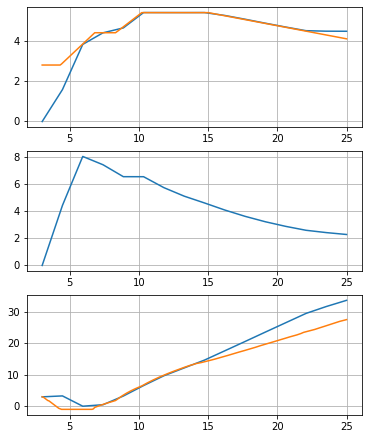

In [32]:
# The summary stats per each file are here:
ss = la.summary_stats

ss['GenSpeed']['mean']

chans = ['GenSpeed','TSR','BldPitch1']

ss['TSR']
ss['TSR'] = ss['RotSpeed']['mean'] * 120 / ss['Wind1VelX']['mean'] * rpm2RadSec

fig, axs = plt.subplots(len(chans),1)

fig.set_size_inches(6,2.5*len(chans))

for i_chan, chan in enumerate(chans):
    
    try:
        axs[i_chan].plot(ss['Wind1VelX']['mean'],ss[chan]['mean'])
    except:
        axs[i_chan].plot(ss['Wind1VelX']['mean'],ss[chan])
    

[a.grid(True) for a in axs]


M = np.loadtxt('/Users/dzalkind/Downloads/Megablade_35_sr180_GenEff_control_schedule.txt',delimiter=',')

UU = M[:,0]

rot_speed = M[:,1] * rpm2RadSec

rot_speed

min_pitch = np.deg2rad(M[:,2])

min_pitch

ds = 1

# fig, axs = plt.subplots(2,1)

# axs[0].plot(UU,rot_speed)
axs[0].plot(UU[::ds],rot_speed[::ds]/ rpm2RadSec)
# axs[1].plot(UU,min_pitch)
axs[2].plot(UU[::ds],np.rad2deg(min_pitch[::ds]))


In [20]:
dlcs = ['1.6','6.1']
# dlcs = ['1.1','1.3','1.4','1.5']
channels = ['GenSpeed','PtfmSurge', 'PtfmSway', 'PtfmHeave', 'PtfmRoll','PtfmPitch','PtfmYaw']


for dlc in dlcs:
    for chan in channels:
        ss_max = ss.reset_index()[dlc_inds[dlc]][chan]['max']
        ss_min = ss.reset_index()[dlc_inds[dlc]][chan]['min']
        i_max = ss_max.argmax()
        i_min = ss_min.argmin()
        print(f"DLC {dlc}: Max {chan} of {ss_max.max():.3f} in {ss.index[ss_max.index[i_max]]}")
        print(f"DLC {dlc}: Min {chan} of {ss_min.min():.3f} in {ss.index[ss_min.index[i_min]]}")

NameError: name 'dlc_inds' is not defined

In [27]:
ss['TSR'] = 1

ss['TSR']

IEA15MW_PRC_00.out    1
IEA15MW_PRC_01.out    1
IEA15MW_PRC_02.out    1
IEA15MW_PRC_03.out    1
IEA15MW_PRC_04.out    1
IEA15MW_PRC_05.out    1
IEA15MW_PRC_06.out    1
IEA15MW_PRC_07.out    1
IEA15MW_PRC_08.out    1
IEA15MW_PRC_09.out    1
IEA15MW_PRC_10.out    1
IEA15MW_PRC_11.out    1
IEA15MW_PRC_12.out    1
IEA15MW_PRC_13.out    1
IEA15MW_PRC_14.out    1
IEA15MW_PRC_15.out    1
Name: TSR, dtype: int64

In [74]:
la.summary_stats[("Wind1VelX", 'min')]

10.12/7.56

ss.to_pickle("/projects/esteyco/dzalkind/02_DLC_02_1661_NoCW/rank_0/ss_12345.p")

In [27]:
# Or by file
la.summary_stats.loc["BAR10_0_IEC_13.outb"]

Wind1VelX  min           7.331778e+00
Wind1VelY  min          -6.869149e+00
Wind1VelZ  min          -4.288182e+00
Azimuth    min           7.724802e-04
BldPitch1  min           6.118227e+00
                             ...     
GenPwr     integrated   -1.709636e+05
GenTq      integrated    0.000000e+00
RootMc1    integrated    2.066127e+06
RootMc2    integrated    6.123670e+06
RootMc3    integrated    5.847567e+06
Name: BAR10_0_IEC_13.outb, Length: 1104, dtype: float64

In [28]:
# Damage equivalent loads are found here:
la.DELs

,RootMc1,RootMc2,RootMc3
BAR10_0_IEC_13.outb,17155.972672,18123.882926,18975.048930
BAR10_0_IEC_44.outb,20769.760533,20173.288148,20931.456407
BAR10_0_IEC_05.outb,12965.959096,12840.962463,13141.212547
BAR10_0_IEC_29.outb,17868.450676,17151.796573,16319.655247
BAR10_0_IEC_09.outb,15761.531479,16148.632706,16634.678742


In [31]:
# Extreme events:
la.extreme_events['RotSpeed']

[{'Time': 500.02000000000004,
  'RotSpeed': 9.196721076965332,
  'RotThrust': 1832.1434326171875,
  'RotTorq': 19779.529296875,
  'RootMc1': 37811.284398457174,
  'RootMc2': 55838.312057143645,
  'RootMc3': 50827.68616140148},
 {'Time': 368.26,
  'RotSpeed': 9.146635055541992,
  'RotThrust': 1628.4447021484375,
  'RotTorq': 19790.078125,
  'RootMc1': 47771.370180076294,
  'RootMc2': 49087.65189598435,
  'RootMc3': 48430.43687242791},
 {'Time': 368.72,
  'RotSpeed': 9.249673843383789,
  'RotThrust': 2189.477294921875,
  'RotTorq': 19810.16015625,
  'RootMc1': 59575.98150937143,
  'RootMc2': 68240.34957165274,
  'RootMc3': 52813.63114797467},
 {'Time': 356.36,
  'RotSpeed': 9.03768539428711,
  'RotThrust': 1109.2626953125,
  'RotTorq': 19767.958984375,
  'RootMc1': 28428.160164204783,
  'RootMc2': 47520.51453251602,
  'RootMc3': 26678.213325803477},
 {'Time': 218.85,
  'RotSpeed': 8.697166442871094,
  'RotThrust': 1519.8240966796875,
  'RotTorq': 19807.201171875,
  'RootMc1': 42921.23490